In [1]:
%matplotlib inline
from awips.dataaccess import DataAccessLayer, ModelSounding
from awips import ThriftClient
import matplotlib.pyplot as plt
import numpy as np
from metpy.plots import SkewT, Hodograph
from metpy.units import units
import metpy.calc as mpcalc
import metpy.constants as mpconsts
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import sqrt
from datetime import datetime, timedelta
from shapely.geometry import Point, Polygon
import shapely.wkb
import timeit

In [2]:
#model="NAM40"
#model = "HRRR"
model = "RAP13"
parms = ['T','DpT','uW','vW']
server = 'edex-cloud.unidata.ucar.edu'
DataAccessLayer.changeEDEXHost(server)

In [3]:
# note the order is LON,lat and not lat,LON
#point = Point(-104.67,39.87)
point = Point(-87.95, 41.70)

inc = 0.005
bbox=[point.y-inc, point.y+inc, point.x-inc, point.x+inc]
polygon = Polygon([(bbox[0],bbox[2]),(bbox[0],bbox[3]),
                   (bbox[1],bbox[3]),(bbox[1],bbox[2]),
                   (bbox[0],bbox[2])])

In [4]:
# Get latest forecast cycle run
timeReq = DataAccessLayer.newDataRequest("grid")
timeReq.setLocationNames(model)
cycles = DataAccessLayer.getAvailableTimes(timeReq, True)
times = DataAccessLayer.getAvailableTimes(timeReq)
fcstRun = DataAccessLayer.getForecastRun(cycles[-2], times)

print("Using " + model + " forecast time " + str(fcstRun[0]))

Using RAP13 forecast time 2021-07-04 01:00:00


In [5]:
p,t,d,u,v = [],[],[],[],[]
use_parms = ['T','DpT','uW','vW','P']
use_level = "0.0FHAG"
sndObject = ModelSounding.getSounding(model, use_parms,
                                      ["0.0FHAG"], point, 
                                      timeRange=[fcstRun[0]])
                                      #timeRange=[dt2])
if len(sndObject) > 0:
    for time in sndObject._dataDict:
        p.append(float(sndObject._dataDict[time][use_level]['P']))
        t.append(float(sndObject._dataDict[time][use_level]['T']))
        d.append(float(sndObject._dataDict[time][use_level]['DpT']))
        u.append(float(sndObject._dataDict[time][use_level]['uW']))
        v.append(float(sndObject._dataDict[time][use_level]['vW']))
    print("Found surface record at " + "%.1f" % p[0] + "MB")
else:
    raise ValueError("sndObject returned empty for query ["
                    + ', '.join(str(x) for x in (model, use_parms, point, use_level)) +"]")

Found surface record at 988.5MB


In [6]:
# Get isobaric levels with our requested parameters
levelReq = DataAccessLayer.newDataRequest("grid", envelope=point)
levelReq.setLocationNames(model)
levelReq.setParameters('T','DpT','uW','vW')
availableLevels = DataAccessLayer.getAvailableLevels(levelReq)

# Clean levels list of unit string (MB, FHAG, etc.)
levels = []
for lvl in availableLevels:
    name=str(lvl)
    if 'MB' in name and '_' not in name:
        # If this level is above (less than in mb) our 0.0FHAG record
        if float(name.replace('MB','')) < p[0]:
            levels.append(lvl)

# Get Sounding
sndObject = ModelSounding.getSounding(model, parms, levels, point,
                        timeRange=[fcstRun[0]])

if not len(sndObject) > 0:
    raise ValueError("sndObject returned empty for query ["
                    + ', '.join(str(x) for x in (model, parms, point, levels)) +"]")

for time in sndObject._dataDict:
    for lvl in sndObject._dataDict[time].levels():
        for parm in sndObject._dataDict[time][lvl].parameters():
            if parm == "T":
                t.append(float(sndObject._dataDict[time][lvl][parm]))
            elif parm == "DpT":
                d.append(float(sndObject._dataDict[time][lvl][parm]))
            elif parm == 'uW':
                u.append(float(sndObject._dataDict[time][lvl][parm]))
            elif parm == 'vW':
                v.append(float(sndObject._dataDict[time][lvl][parm]))
            else:
                print("WHAT IS THIS")
                print(sndObject._dataDict[time][lvl][parm])
        # Pressure is our requested level rather than a returned parameter
        p.append(float(lvl.replace('MB','')))

# convert to numpy.array()
p = np.array(p, dtype=float)
t = (np.array(t, dtype=float) - 273.15) * units.degC
d = (np.array(d, dtype=float) - 273.15) * units.degC
u = (np.array(u, dtype=float) * units('m/s')).to('knots')
v = (np.array(v, dtype=float) * units('m/s')).to('knots')
w = np.sqrt(u**2 + v**2)

print("Using " + str(len(levels)) + " levels between " +
      str("%.1f" % max(p)) + " and " + str("%.1f" % min(p)) + "MB")

Using 36 levels between 988.5 and 100.0MB


In [7]:
speci_hum = mpcalc.specific_humidity_from_dewpoint(p[0] * units.millibar, d[0])
mixing_rat = mpcalc.mixing_ratio_from_specific_humidity(speci_hum)

#mix_rat_units = units.Quantity()

In [8]:
mixing_array = []
for i in range(len(p)):
    mixing_array.append(mixing_rat)
    
mixing_array = np.array(mixing_array)

In [9]:
mixing_temps = []
mixing_pres = []

for i in range(len(p)):
    mixing_vapor = mpcalc.vapor_pressure(p[i] * units.millibar, mixing_rat)
    mixing_dew = mpcalc.dewpoint(mixing_vapor)
    mixing_temps.append(mixing_dew.magnitude)
    mixing_pres.append(p[i])

In [10]:
CCL = mpcalc.find_intersections(np.array(p), np.array(mixing_temps), np.array(t.m))
CT = mpcalc.dry_lapse(p[0] * units.hectopascal, CCL[1].m * units.degC, reference_pressure = CCL[0].m * units.hectopascal)

In [11]:
print(CT.to('degC').m, CCL[0].m, CCL[1].m)

[34.18948514] [797.57326368] [15.91183381]


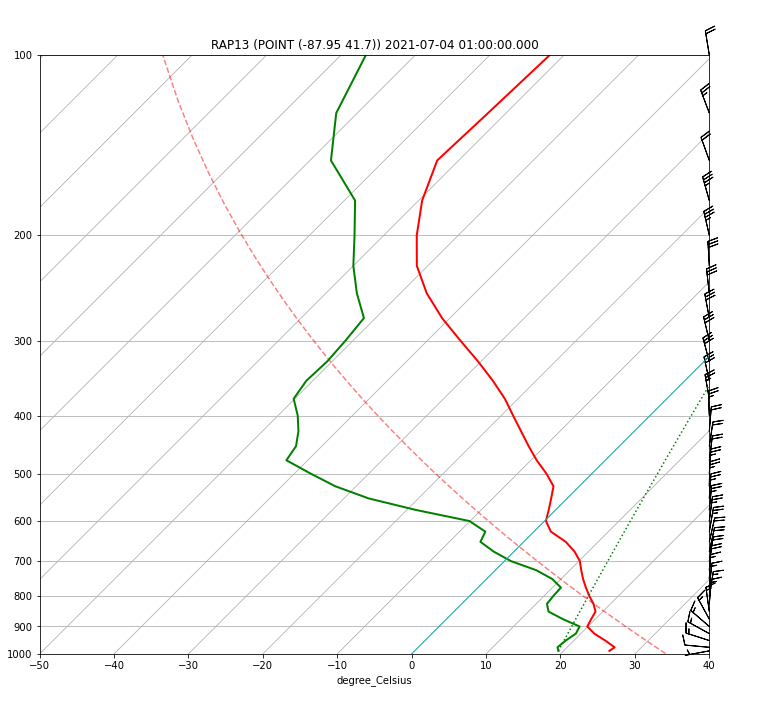

In [12]:
plt.rcParams['figure.figsize'] = (12, 14)

# Skew-T
skew = SkewT(rotation=45)
skew.plot(p, t, 'r', linewidth=2)
skew.plot(p, d, 'g', linewidth=2)
skew.plot(mixing_pres, mixing_temps, 'g', linestyle=':')
skew.plot_barbs(p, u, v)
#skew.ax.plot(CCL[0].m * units.millibar , CCL[1].m * units.degC, marker="o", color='orange', markersize=10, markeredgewidth=3)
skew.plot_dry_adiabats(t0 = CT.to('degC'))
#skew.plot_moist_adiabats()
#skew.plot_mixing_lines(mixing_ratio = np.array([mixing_rat]).reshape(-1, 1) ,linestyle=':')

skew.ax.set_ylim(1000, np.min(p))
skew.ax.set_xlim(-50, 40)

# Title
plt.title( model + " (" + str(point) + ") " + str(time.getRefTime()))


# Hodograph
#ax_hod = inset_axes(skew.ax, '40%', '40%', loc=2)
#h = Hodograph(ax_hod, component_range=max(w.magnitude))
#h.add_grid(increment=20)
#h.plot_colormapped(u, v, w)

# Dotted line at 0C isotherm
l = skew.ax.axvline(0, color='c', linestyle='-', linewidth=1)

plt.show()


In [13]:
def CCL_CT_Calc(p, t, d):
    """
    A definition that calculates the Convective Cloud Level (CCL)
    and Convective Temperature (CT) of sounding data. This data 
    should be array-like. p is pressure array, t is temperature
    array, d is dewpoint array. Metpy and Numpy is required. Units should 
    be in celsius for temperatures and millibars or hecto-pascals
    for pressure and should be attached before entering definition.
    Returns the pressure level and temperature at which the CCL is 
    located and then the CT, all respectively.
    """
    
    #Calculate the mixing ratio from the surface parameters.
    spc_hum = mpcalc.specific_humidity_from_dewpoint(p[0], d[0])
    mix_rat = mpcalc.mixing_ratio_from_specific_humidity(spc_hum)
    
    #Create mixing ratio line used to find intersect of temperature profile.
    mt = []
    
    for i in range(len(p)):
        mixing_vapor = mpcalc.vapor_pressure(p[i], mix_rat)
        mixing_dew = mpcalc.dewpoint(mixing_vapor)
        mt.append(mixing_dew.magnitude)
    
    #Calculate the intersection of the mixing ratio and temperature profile.
    CCL = mpcalc.find_intersections(np.array(p), np.array(mixing_temps), np.array(t.m))
    
    #Calculate the CT using the dry lapse rate given 
    CT = mpcalc.dry_lapse(p[0], CCL[1].m * units.degC, reference_pressure = CCL[0].m * units.hectopascal)
    
    return(CCL[0].m, CCL[1].m, CT.to('degC').m)